Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [1]:
NAME = "Anamarija Hauptman"
COLLABORATORS = None

---

# Domača naloga 6: Geometrijska kalibracija kamere

1. Napišite funkcijo, ki za dane optimalne parametre geometrijske kalibracije `iPar` normalizira zajeto sliko `iImage` v metrični prostor:
```python
    def geomCalibImage( iPar, iImage, iCoorX, iCoorY ):
        return oImage
```
kjer spremenljivki `iCoorX` in `iCoorY` predstavljata koordinate točk $(x,y)$ **v metričnem prostoru**, ki jih je potrebno preslikati v prostor slike in določiti pripadajoče sivinske vrednosti. Funkcija vrne kalibrirano sliko `oImage`, katere dimenzije so podane glede na dimenzije vzorčnih točk $(x,y)$.

 Preverite delovanje funkcije tako, da vzorčne točke $(x,y)$ preslikate z optimalnimi parametri projektivne preslikave in modela radialnih distorzij. Predpostavite, da ima stranica kvadratnega polja kalibracijskega objekta dolžino 20 mm in ustvarite točke $(x,y)$ tako, da bo na izhodni kalibrirani sliki `oImage` velikost slikovnih elementov enaka $1/5\,$ mm. Izvedite geometrijsko kalibracijo slike `data/calibration-object.jpg` tako, da s funkcijo za interpolacijo prvega reda `scipy.interpolate.interpn()` v preslikanih točkah poiščete nove sivinske vrednosti. Prikažite preslikano sliko, v kateri morajo biti vzorci v kalibru poravnani z osmi slike.

Naložite module in prilepite zahtevane funkcije iz vaj:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import PIL.Image as im
from scipy.interpolate import interpn
import cv2 as cv

In [3]:
def loadImage(iPath):
    oImage = np.array(im.open(iPath))
    if oImage.ndim == 3:
        oImage = np.transpose(oImage, [2, 0, 1])
    elif oImage.ndim == 2:
        oImage = np.transpose(oImage, [1, 0])
    return oImage

def showImage(iImage, iTitle=''):
    plt.figure()
    plt.imshow(iImage, cmap = 'gray')
    plt.suptitle(iTitle)
    #plt.xlabel('x')
    #plt.ylabel('y')

def transProjective2D(iPar, iCoorX, iCoorY):
    """Funkcija za projektivno preslikavo"""
    iPar = np.asarray(iPar)
    iCoorX = np.asarray(iCoorX)
    iCoorY = np.asarray(iCoorY)
    if np.size(iCoorY) != np.size(iCoorX):
        print("Stevilo X in Y koordinat razlicno!")
    # izvedi projektivno rpeslikava
    # iPar = [a11, a12, tx, a21, a22, ty, px, py]
    oDenom = iPar[6] * iCoorX + iPar[7] * iCoorY + 1
    oCoorU = iPar[0] * iCoorX + iPar[1] * iCoorY + iPar[2]
    oCoorV = iPar[3] * iCoorX + iPar[4] * iCoorY + iPar[5]
    # vrni preslikane tocke
    return oCoorU/oDenom, oCoorV/oDenom

def transRadial(iK, iUc, iVc, iCoorU, iCoorV):
    """Funkcija za preslikavo z Brownovim modelom distorzij"""    
    # Preveri vhodne podatke
    iK = np.array(iK)
    iCoorU = np.array(iCoorU)
    iCoorV = np.array(iCoorV)
    if np.size(iCoorU) != np.size(iCoorV):
        print("Stevio U n V koordinat razlicno!")
    # odstej koordinate cenra
    oCoorUd = iCoorU - iUc; oCoorVd = iCoorV - iVc
    # pripravi izhone koordinate
    sUd = np.max(np.abs(oCoorUd))
    sVd = np.max(np.abs(oCoorVd))
    
    oCoorUd = oCoorUd / sUd
    oCoorVd = oCoorVd / sVd
    
    # preracunaj radialna popacenja
    R2 = oCoorUd**2.0 + oCoorVd **2.0
    iK = iK.flatten()
    oCoorRd = np.ones_like(oCoorUd)
    
    for i in range(iK.size):
        oCoorRd = oCoorRd + iK[i]*(R2**(i+1))
    # izracunaj izhodne koorniate
    oCoorUd = oCoorUd * oCoorRd * sUd + iUc
    oCoorVd = oCoorVd * oCoorRd * sVd + iVc
    # END SOLUTION
    return oCoorUd, oCoorVd

def geomCalibTrans(iPar, iCoorX, iCoorY):
    """Funkcija za preslikavo tock (projektivna+radialne distorzije)"""
    iParProj = iPar[0:8]
    iParRad = iPar[8:]
    #preslikava v prostor slike
    iCoorUt, iCoorVt = transProjective2D(iParProj, iCoorX, iCoorY)
    # korekcija radialnih distorzij
    iCoorUt, iCoorVt = transRadial(iParRad[2:], iParRad[0], iParRad[1], iCoorUt, iCoorVt)
    # vrni preslikane tocke
    return iCoorUt, iCoorVt

def colorToGray(iImage):
    dtype = iImage.dtype
    r = iImage[:,:,0].astype('float')
    g = iImage[:,:,1].astype('float')
    b = iImage[:,:,2].astype('float')
    
    return (r*0.299 + g*0.587 + b*0.114).astype(dtype)

def mapAffineApprox2D(iPtsRef, iPtsMov):
    """Afina aproksimacijska poravnava"""
    iPtsRef = np.matrix(iPtsRef) 
    iPtsMov = np.matrix(iPtsMov) 
    # po potrebi dodaj homogeno koordinato
    iPtsRef = addHomCoord2D(iPtsRef)
    iPtsMov = addHomCoord2D(iPtsMov)
    # afina aproksimacija (s psevdoinverzom)
    iPtsRef = iPtsRef.transpose()
    iPtsMov = iPtsMov.transpose()            
    # psevdoinverz
    #oMat2D = np.dot(iPtsRef, np.linalg.pinv(iPtsMov))        
    # psevdoinverz na dolgo in siroko:
    oMat2D = iPtsRef * iPtsMov.transpose() * \
    np.linalg.inv( iPtsMov * iPtsMov.transpose() )
    return oMat2D

def addHomCoord2D(iPts):
    if iPts.shape[-1] == 3:
        return iPts
    iPts = np.hstack((iPts, np.ones((iPts.shape[0], 1))))
    return iPts

def geomCalibErr(iPar, iCoorU, iCoorV, iCoorX, iCoorY):
    """Funkcija za izracun kalibracijske napake"""
    iCoorUt, iCoorVt = geomCalibTrans(iPar, iCoorX, iCoorY)
    #izracun napake poravnave
    oErr2 = np.mean((iCoorU - iCoorUt)**2 + (iCoorV - iCoorVt)**2)
    # vrni vrednost napake
    return oErr2

Implementirajte funkcijo `geomCalibImage`:

In [4]:
def geomCalibImage(iPar, iImage, iCoorX, iCoorY):
    """Funkcija za normalizacijo slike po geometrijski kalibraciji"""
    # YOUR CODE HERE
    #oCoorU, oCoorV = transProjective2D(iPar, iCoorX, iCoorY)
    oCoorUt, oCoorVt = transProjective2D(iPar, iCoorX, iCoorY)
    #if iImage.shape[0] == 3:
    #    iImage = np.transpose(iImage, (1, 2, 0))
    #iImage = colorToGray(iImage)
    dy = iImage.shape[0]
    dx = iImage.shape[1]
    s = 1
    oImage = interpn((np.arange(dy), np.arange(dx)),
                      iImage,
                      (oCoorVt[::s,::s], oCoorUt[::s,::s]),
                      method = "linear", bounds_error=False)
    square = 100
    #raise NotImplementedError()
    return oImage[0:(10*square), 0:(14*square)]

 Preverite delovanje funkcije tako, da vzorčne točke $(x,y)$ preslikate z optimalnimi parametri projektivne preslikave in modela radialnih distorzij. Predpostavite, da ima stranica kvadratnega polja kalibracijskega objekta dolžino 20 mm in ustvarite točke $(x,y)$ tako, da bo na izhodni kalibrirani sliki `oImage` velikost slikovnih elementov enaka $1/5\,$ mm. Izvedite geometrijsko kalibracijo slike `data/calibration-object.jpg` tako, da s funkcijo za interpolacijo prvega reda `scipy.interpolate.interpn()` v preslikanih točkah poiščete nove sivinske vrednosti. Prikažite preslikano sliko, v kateri morajo biti vzorci v kalibru poravnani z osmi slike.

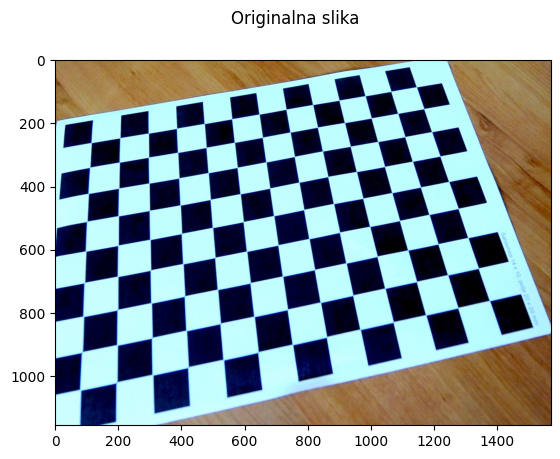

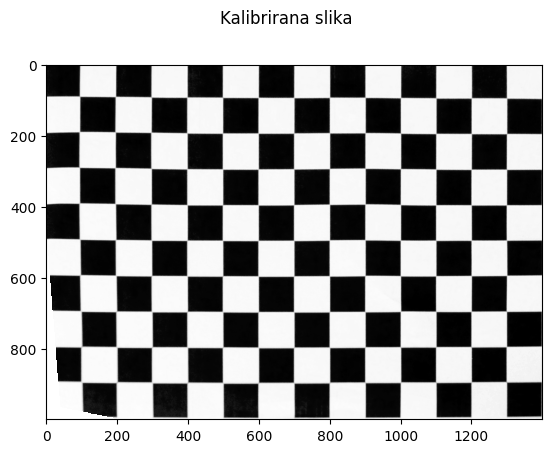

In [5]:
# Primer parametrov
iCalImage = loadImage('data/calibration-object.jpg')
iPar = [4.452, -0.349, 34.207, -0.709,
        3.352, 211.927, 2.459e-04, -1.348e-03,
        1963.270, 1478.125, 1.101e-03]
# YOUR CODE HERE
#points = [(110.28629032258064, 266.0322580645163), (645.2258064516128, 177.4032258064517),
#          (1151.6774193548385, 88.77419354838707), (1240.3064516129032, 389.47983870967755),
#          (1373.2499999999998, 772.4838709677421), (752.8467741935483, 905.4274193548388),
#          (81.79838709677418, 1054.1975806451615), (94.45967741935479, 604.7217741935485)]
#pts = np.array(points)
iCalImage = np.transpose(iCalImage, (1, 2, 0))
iCalImage_g = colorToGray(iCalImage)
showImage(iCalImage, 'Originalna slika')
# ustvari mrezo tock
iCoorX, iCoorY = np.meshgrid(range(iCalImage_g.shape[1]), 
                             range(iCalImage_g.shape[0]),
                             sparse=False, indexing='xy')
iCoorX = iCoorX / 5
iCoorY = iCoorY / 5
oImage = geomCalibImage(iPar, iCalImage_g, iCoorX, iCoorY)
showImage(oImage, 'Kalibrirana slika')
#raise NotImplementedError()

2. Barvno sliko objekta `data/test-object.jpg`, ki je bila zajeta z istim slikovnim sistemom kot slika kalibra, kalibrirajte z referenčno geometrijsko kalibracijo tako, da bo velikost slikovnega elementa enaka $1/3\,$ mm. Prikažite kalibrirano barvno sliko in nato na merilu označite daljico med kljunoma kljunastega merila ter izračunajte njeno dolžino v mm. Preverite ali dolžina ustreza dolžini, ki je označena na kljunastem merilu.


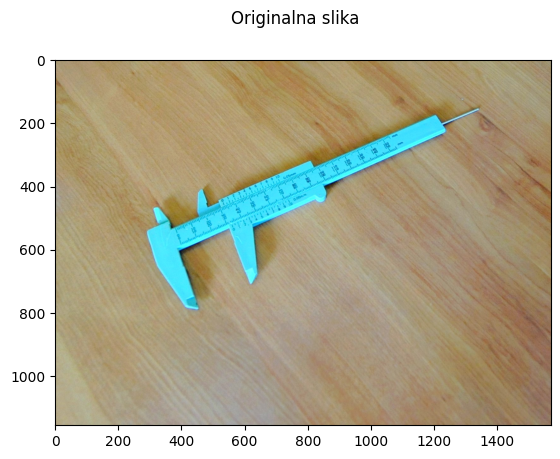

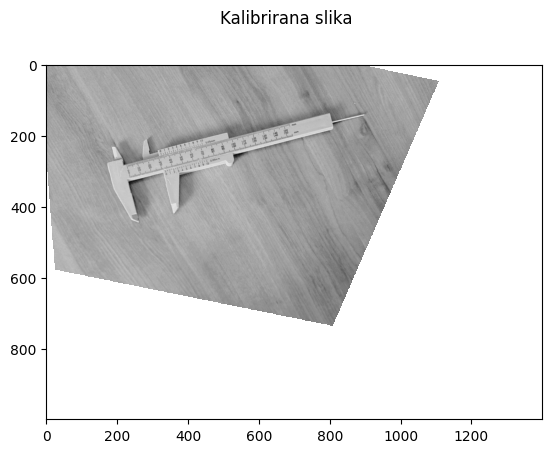

In [6]:
# Kalibrirajte sliko, jo prikazite in na njej oznacite tocki, 
# ki dolocata razdaljo med kljunoma
# YOUR CODE HERE
iPar = [4.452, -0.349, 34.207, -0.709,
        3.352, 211.927, 2.459e-04, -1.348e-03,
        1963.270, 1478.125, 1.101e-03]
iTestImage = loadImage('data/test-object.jpg')
iTestImage = np.transpose(iTestImage, (1, 2, 0))
iTestImage_g = colorToGray(iTestImage)
showImage(iTestImage, 'Originalna slika')
# ustvari mrezo tock
iCoorX, iCoorY = np.meshgrid(range(iTestImage_g.shape[1]), 
                             range(iTestImage_g.shape[0]),
                             sparse=False, indexing='xy')
iCoorX = iCoorX / 3
iCoorY = iCoorY / 3
oImageT = geomCalibImage(iPar, iTestImage_g, iCoorX, iCoorY)
showImage(oImageT, 'Kalibrirana slika')
#raise NotImplementedError()

razdalja: 32.80394991452517mm
Dolžina približno ustreza dolžini, ki je označena na kljunastem merilu.


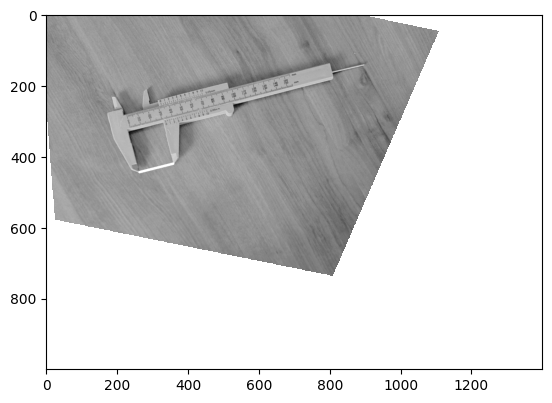

In [7]:
# Izracunajte in izpisite izmerejeno razdaljo med kljunoma
# YOUR CODE HERE
'''
tocke sem dobila s pomocjo skripte select_points_calib.py iz vaj
'''

kljun_10 = [[(263.44952505122, 445.7008499974602), (359.36039384344474, 420.25510929748225)],
            [(263.44952505122, 445.7008499974602), (359.36039384344474, 422.2124739667113)],
            [(265.40688972044904, 445.7008499974602), (359.36039384344474, 422.2124739667113)],
            [(263.44952505122, 445.7008499974602), (359.36039384344474, 422.2124739667113)],
            [(265.40688972044904, 445.7008499974602), (359.36039384344474, 420.25510929748225)],
            [(261.49216038199086, 443.74348532823115), (359.36039384344474, 422.2124739667113)],
            [(263.44952505122, 441.7861206590021), (359.36039384344474, 422.2124739667113)],
            [(263.44952505122, 445.7008499974602), (359.36039384344474, 420.25510929748225)],
            [(265.40688972044904, 445.7008499974602), (359.36039384344474, 420.25510929748225)],
            [(263.44952505122, 445.7008499974602), (359.36039384344474, 422.2124739667113)]]

kljun = np.mean(np.array(kljun_10), axis=0)
kljun = [tuple(coord) for coord in kljun]

x1 = kljun[0][0]
y1 = kljun[0][1]
x2 = kljun[1][0]
y2 = kljun[1][1]

dx = x2 - x1
dy = y2 - y1
dst = np.sqrt(dx**2 + dy**2)
print('razdalja: ' + str(dst / 3) + 'mm')
print('Dolžina približno ustreza dolžini, ki je označena na kljunastem merilu.')

cv.line(oImageT, ([int(x1), int(y1)]), ([int(x2), int(y2)]), (255, 0, 0), 5)
showImage(oImageT)
#raise NotImplementedError()

3. Geometrijsko kalibracijo ponovite $3\times$ tako, da najprej $3\times$ ročno označite oglišča na sliki s kalibracijskim objektom `data/calibration-object.jpg`. Referenčno geometrijsko kalibracijo nato določite glede na povprečne koordinate teh oglišč. Na podlagi referenčne geometrijske kalibracije ocenite točnost geometrijske kalibracije z ročno označenimi oglišči (tiste geometrijske kalibracije, ki ste jo izračunali na vajah) v milimetrih. Od česa zavisi točnost geometrijske kalibracije?

In [8]:
# Oznacite oglisca na sliki (vsako oglisce 3 krat)
# YOUR CODE HERE
'''
tocke sem dobila s pomocjo skripte select_points_calib.py iz vaj
'''
oglisca_3 = [[(116.6471748590393, 265.62330042838516), (645.1356355508896, 173.62716097461862), (1142.3062615350746, 89.46048019776845),
              (1244.0892243349867, 388.937274589817), (1375.2326571733347, 766.7086557510287), (750.8333276892596, 903.724182597064),
              (79.45724614368692, 1046.6118034507865), (99.03089283597762, 608.1621175434735)],
             [(116.6471748590393, 263.6659357591561), (645.1356355508896, 175.58452564384766), (1142.3062615350746, 89.46048019776845),
              (1246.0465890042155, 386.97990992058794), (1375.2326571733347, 762.7939264125705), (750.8333276892596, 901.7668179278348),
              (79.45724614368692, 1046.6118034507865), (97.07352816674859, 608.1621175434735)],
             [(116.6471748590393, 265.62330042838516), (649.0503648893479, 175.58452564384766), (1144.2636262043038, 87.50311552853941),
              (1244.0892243349867, 386.97990992058794), (1373.2752925041054, 762.7939264125705), (750.8333276892596, 901.7668179278348),
              (79.45724614368692, 1044.6544387815575), (97.07352816674859, 608.1621175434735)]]

points = [(116.61693548387095, 266.0322580645163),
          (645.2258064516128, 171.07258064516145),
          (1139.0161290322578, 82.44354838709683),
          (1243.4717741935483, 386.3145161290323),
          (1370.0846774193546, 762.9879032258066),
          (752.8467741935483, 902.2620967741937),
          (81.79838709677418, 1047.8669354838712),
          (100.79032258064515, 607.8870967741937)] #rocno oznacena ogljisca z vaj
#raise NotImplementedError()

povprecna oglisca: [(116.6471748590393, 264.97084553864215), (646.4405453303757, 174.93207075410464), (1142.9587164248176, 88.80802530802544), (1244.7416792247298, 387.63236481033096), (1374.5802022835917, 764.0988361920566), (750.8333276892596, 902.419272817578), (79.45724614368692, 1045.9593485610435), (97.7259830564916, 608.1621175434735)]


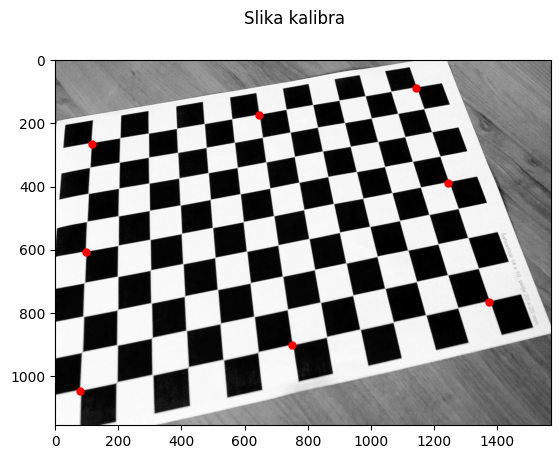

In [9]:
# Izracunajte povprecje oglisc in iz dobljenih povprecnih oglisc
# izracunajte geometrijsko kalibracijo
# YOUR CODE HERE
oglisca = np.mean(np.array(oglisca_3), axis=0)
oglisca = [tuple(coord) for coord in oglisca]
print('povprecna oglisca:', oglisca)

pts = np.array(oglisca)
iCalImageG = colorToGray(iCalImage)
showImage(iCalImageG, 'Slika kalibra')
plt.plot(pts[:, 0], pts[:, 1], 'or', markersize=5.0)        
# koordinate v prostoru slike
iCoorU = pts[:, 0].flatten()
iCoorV = pts[:, 1].flatten()
# koordinate kalibra v metricnem prostoru
iCoorX = np.array([20, 140, 260, 260, 260, 140,  20,  20])
iCoorY = np.array([20,  20,  20, 100, 180, 180, 180, 100])
# oblikuj koordinate v matrike (Nx2)
ptsUV = np.vstack((iCoorU, iCoorV)).transpose()
ptsXY = np.vstack((iCoorX, iCoorY)).transpose()
# doloci zacetni priblizek parametrov
oMatA = mapAffineApprox2D(ptsUV, ptsXY)
#    oMatA = rvlib.mapAffineApprox2D( ptsXY, ptsUV )
# preslikava identiteta
Uc = iCalImageG.shape[1] / 2
Vc = iCalImageG.shape[0] / 2
iParIdent = np.array([1, 0, 0, 0, 1, 0, 0, 0, Uc, Vc, 0])
# preslikava z afinim priblizkom
Uc = iCalImageG.shape[1] / 2
Vc = iCalImageG.shape[0] / 2
iParAffine = np.array([oMatA[0, 0], oMatA[0, 1], oMatA[0, 2],\
                       oMatA[1, 0], oMatA[1, 1], oMatA[1, 2],\
                       0, 0, Uc, Vc, 0])
# doloci napako z danimi parametri
oErr2ident_3 = geomCalibErr(iParIdent, iCoorU, iCoorV, iCoorX, iCoorY)
oErr2affine_3 = geomCalibErr(iParAffine, iCoorU, iCoorV, iCoorX, iCoorY)
#print('ident err:', oErr2ident_3)
#print('affine err:', oErr2affine_3)

err_ref = oErr2affine_3
#raise NotImplementedError()

napaka kalibracije iz vaj glede na referencno kalibracijo: 77.34481459904964


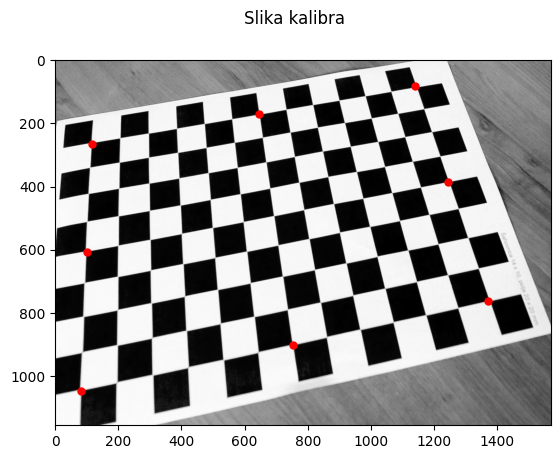

In [10]:
# Z dobljeno referencno kalibracijo ocenite tocnost 
# geometrijske kalibracije iz vaj v milimetrih
# YOUR CODE HERE
pts = np.array(points)
iCalImageG = colorToGray(iCalImage)
showImage(iCalImageG, 'Slika kalibra')
plt.plot(pts[:, 0], pts[:, 1], 'or', markersize=5.0)        
# koordinate v prostoru slike
iCoorU = pts[:, 0].flatten()
iCoorV = pts[:, 1].flatten()
# koordinate kalibra v metricnem prostoru
iCoorX = np.array([20, 140, 260, 260, 260, 140,  20,  20])
iCoorY = np.array([20,  20,  20, 100, 180, 180, 180, 100])
# oblikuj koordinate v matrike (Nx2)
ptsUV = np.vstack((iCoorU, iCoorV)).transpose()
ptsXY = np.vstack((iCoorX, iCoorY)).transpose()
# doloci zacetni priblizek parametrov
oMatA = mapAffineApprox2D(ptsUV, ptsXY)
#    oMatA = rvlib.mapAffineApprox2D( ptsXY, ptsUV )
# preslikava identiteta
Uc = iCalImageG.shape[1] / 2
Vc = iCalImageG.shape[0] / 2
iParIdent = np.array([1, 0, 0, 0, 1, 0, 0, 0, Uc, Vc, 0])
# preslikava z afinim priblizkom
Uc = iCalImageG.shape[1] / 2
Vc = iCalImageG.shape[0] / 2
iParAffine = np.array([oMatA[0, 0], oMatA[0, 1], oMatA[0, 2],\
                       oMatA[1, 0], oMatA[1, 1], oMatA[1, 2],\
                       0, 0, Uc, Vc, 0])
# doloci napako z danimi parametri
oErr2ident_1 = geomCalibErr(iParIdent, iCoorU, iCoorV, iCoorX, iCoorY)
oErr2affine_1 = geomCalibErr(iParAffine, iCoorU, iCoorV, iCoorX, iCoorY)
#print('ident err:', oErr2ident_1)
#print('affine err:', oErr2affine_1)

err_vaje = oErr2affine_1

print('napaka kalibracije iz vaj glede na referencno kalibracijo:', err_ref - err_vaje)
#raise NotImplementedError()

Od česa zavisi točnost kalibracije?

od točnosti izbire točk na šahovnici

4. Razvijte avtomatski postopek za geometrijsko kalibracijo slikovnega sistema. S pomočjo Harrisovega detektorja oglišč iz knjižnice OpenCV (Vaja 4) poiščite oglišča na sliki kalibra `data/calibration-object.jpg`. Nato pa s funkcijo `cv2.cornerSubPix()` še dodatno izpopolnite položaj oglišč. Ustvarite idealno mrežo referenčnih oglišč in s postopkom ICP (Vaja 5) ter afino preslikavo določite korespondence z zaznanimi oglišči na sliki kalibra. Določite natančnost avtomatske v primerjavi z referenčno geometrijsko kalibracijo v mm. Poizkusite izboljšati natančnost kalibracije še tako, da avtomatsko glede na lastne pogoje zavržete korespondence, ki slabšajo kalibracijo.

In [11]:
deg2rad = lambda a: a*np.pi/180

def transAffine2D(iScale=(1, 1), iTrans=(0, 0), iRot=0, iShear=(0, 0)):
    iRot = deg2rad(iRot)
    oMatScale = np.array([[iScale[0],         0, 0],
                          [        0, iScale[1], 0],
                          [        0,         0, 1]])
    oMatTrans = np.array([[1, 0, iTrans[0]],
                          [0, 1, iTrans[1]],
                          [0, 0,         1]])
    oMatRot = np.array([[np.cos(iRot), -np.sin(iRot), 0],
                        [np.sin(iRot),  np.cos(iRot), 0],
                        [           0,             0, 1]])
    oMatShear = np.array([[        1, iShear[0], 0],
                          [iShear[1],         1, 0],
                          [        0,         0, 1]])
    oMat2D = np.dot(oMatTrans, np.dot(oMatShear, np.dot(oMatRot, oMatScale)))
    return oMat2D

def addHomCoord2D(iPts):
    if iPts.shape[-1] == 3:
        return iPts
    iPts = np.hstack((iPts, np.ones((iPts.shape[0], 1))))
    return iPts

def mapAffineApprox2D(iPtsRef, iPtsMov): # referencne = U
    """Afina aproksimacijska poravnava"""
    # U = TX
    # UX'(XX')^(-1) = T
    iPtsRef = np.matrix(iPtsRef) # U
    iPtsMov = np.matrix(iPtsMov) # X
    # po potrebi dodaj homogeno koordinato
    iPtsRef = addHomCoord2D(iPtsRef)
    iPtsMov = addHomCoord2D(iPtsMov)
    #afina aproksimacia (s psevdoinvrzom XX')
    iPtsRef = iPtsRef.transpose()
    iPtsMov = iPtsMov.transpose()
    #psevdoinverz
    oMat2D = np.dot(iPtsRef, np.linalg.pinv(iPtsMov))
    #oMat2D = iPtsRef*iPtsMov.transpose() * np.linalg.inv(iPts......)
    # Lahko uporabljamo *, ker imamo matrike. Če bi imeli array bi morali uporabljati np.dot 
    return oMat2D 

def findCorrespondingPoints(iPtsRef, iPtsMov):
    """Poisci korespondence kot najblizje tocke"""
    # inicializiraj polje indeksov
    iPtsMov = np.array(iPtsMov)
    iPtsRef = np.array(iPtsRef)
    
    idxPair = -np.ones((iPtsRef.shape[0],1), dtype='int32')
    idxDist = np.ones((iPtsRef.shape[0], iPtsMov.shape[0])) # za shranjevanje razdalij
    
    for i in range(iPtsRef.shape[0]):
        for j in range(iPtsMov.shape[0]):
            idxDist[i, j] = np.sum((iPtsRef[i, :2] - iPtsMov[j, :2])**2)
    # doloci bijektivno preslikavo
    while not np.all(idxDist == np.inf):
        i, j = np.where(idxDist == np.min(idxDist))
        idxPair[i[0]] = j[0]
        idxDist[i[0], :] = np.inf # nasli smo match in smo dali vse ostale pare, ki vsebuje eno od teh tock na Inf
        idxDist[:, j[0]] = np.inf
    # doloci pare tock
    idxValid, idxNotValid = np.where(idxPair >= 0)
    idxValid = np.array(idxValid)
    iPtsRef_t = iPtsRef[idxValid, :]
    iPtsMov_t = iPtsMov[idxPair[idxValid].flatten(), :]
    return iPtsRef_t, iPtsMov_t

def alignICP(iPtsRef, iPtsMov, iEps=1e-6, iMaxIter=50, plotProgress=False):
    """Postopek iterativno najblizje tocke"""
    # inicializiraj izhodne parametre
    curMat = [] # seznam za shranjevanje matrik na vsakem koraku
    oErr = []
    iCurIter = 0
    if plotProgress:
        iPtsMov0 = np.matrix(iPtsMov)
        fig = plt.figure()
        ax = fig.add_subplot(111)
    
    #zacni iterativni postopek
    while True:
        #poisci korespondencn tocke
        iPtsRef_t, iPtsMov_t = findCorrespondingPoints(iPtsRef, iPtsMov)
        #doloci afino aproskimacijsko preslkavo 
        oMat2D = mapAffineApprox2D(iPtsRef_t, iPtsMov_t)
        #pososdobi posamezne tocke
        iPtsMov = np.dot(addHomCoord2D(iPtsMov), oMat2D.transpose())
        # izracunaj napako
        curMat.append(oMat2D)
        oErr.append(np.sqrt(np.sum((iPtsRef_t[:, :2] - iPtsMov_t[:, :2])**2)))
        iCurIter +=1
        # preveri kontroln parametre
        dMat = np.abs(oMat2D - transAffine2D())
        if iCurIter > iMaxIter or np.all(dMat < iEps):
            break
    # doloci kompozitum preslikav
    oMat2D = transAffine2D()
    for i in range(len(curMat)):
        if plotProgress:
            iPtsMov_t = np.dot(addHomCoord2D(iPtsMov0), oMat2D.transpose())
            ax.clear()
            ax.plot(iPtsRef[:, 0], iPtsRef[:, 1], 'ob')
            ax.plot(iPtsMov_t[:, 0], iPtsMov_t[:, 1], 'om')
            fig.canvas.draw()
            plt.pause(1)
        oMat2D = np.dot(curMat[i], oMat2D)
    return oMat2D, oErr

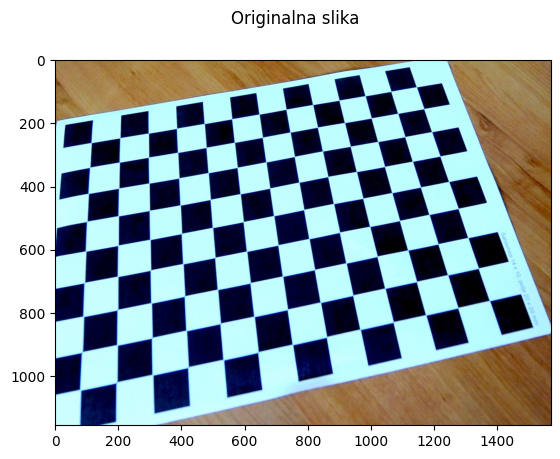

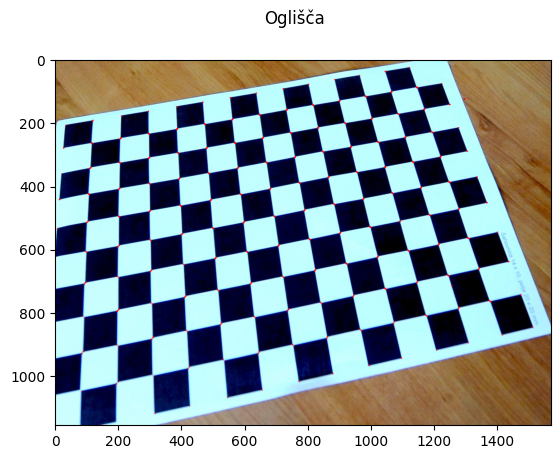

In [12]:
# YOUR CODE HERE
img = cv.cvtColor(cv.imread('data/calibration-object.jpg'), cv.COLOR_BGR2RGB)
showImage(img, 'Originalna slika')
img_g = np.float32(cv.cvtColor(img, cv.COLOR_RGB2GRAY))
#showImage(img_g, 'Sivinska slika')
corners = cv.cornerHarris(img_g, 2, 3, 0.04)
corners = cv.dilate(corners, None)
idx = (corners > 0.01 * corners.max())
img[idx] = [255, 0, 0]
showImage(img, 'Oglišča')
#raise NotImplementedError()

C:\Users\Anamarija\AppData\Local\Temp\ipykernel_10600\451596095.py:13: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  res = np.int0(res)


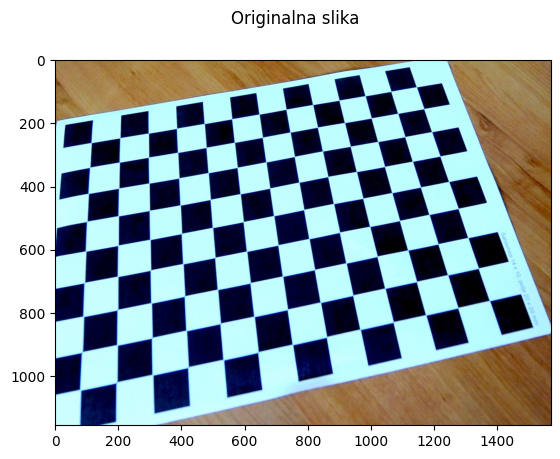

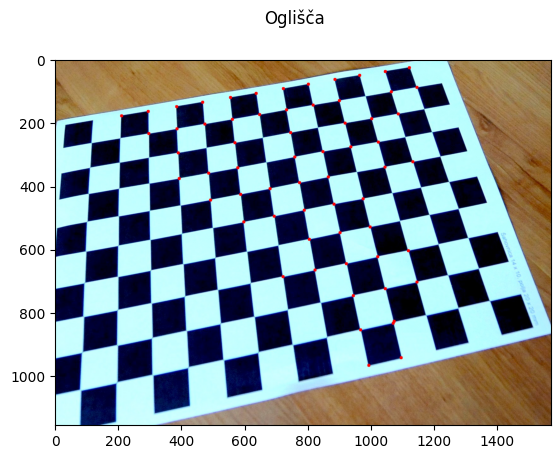

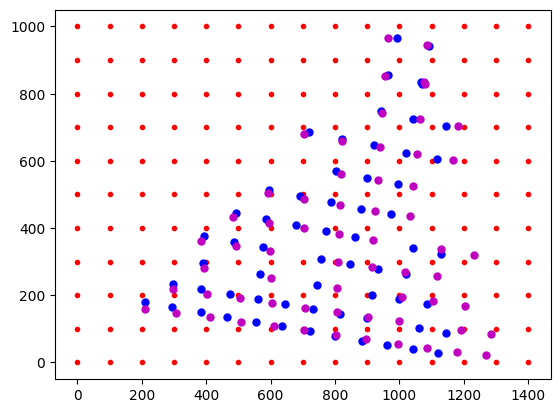

In [13]:
img = cv.cvtColor(cv.imread('data/calibration-object.jpg'), cv.COLOR_BGR2RGB)
showImage(img, 'Originalna slika')
img_g = np.float32(cv.cvtColor(img, cv.COLOR_RGB2GRAY))
#showImage(img_g, 'Sivinska slika')
dst = cv.cornerHarris(img_g, 2, 3, 0.04)
dst = cv.dilate(dst, None)
ret, dst = cv.threshold(dst, 0.01 * dst.max(), 255, 0)
dst = np.uint8(dst)
ret, labels, stats, centroids = cv.connectedComponentsWithStats(dst)
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 100, 0.001)
corners = cv.cornerSubPix(img_g, np.float32(centroids), (5, 5), (-1, -1), criteria)
res = np.hstack((centroids, corners))
res = np.int0(res)
img[res[:, 1], res[:, 0]] = [255, 0, 0]
img[res[:, 3], res[:, 2]] = [0, 255, 0]
idxR = (img[:, :, 0] == 255)
idxG = (img[:, :, 1] == 0)
idxB = (img[:, :, 2] == 0)
idx1 = np.logical_and(idxR, idxG, idxB)
unique1, counts1 = np.unique(idx1, return_counts=True)
#print(unique1, counts1)
idxR = (img[:, :, 0] == 0)
idxG = (img[:, :, 1] == 255)
idxB = (img[:, :, 2] == 0)
idx2 = np.logical_and(idxR, idxG, idxB)
unique2, counts2 = np.unique(idx2, return_counts=True)
#print(unique2, counts2)
pointsMov = []
for i in range(len(idx1)):
    for j in range(i):
        if idx1[j, i]:
            cv.circle(img, (i, j), 5, (255, 0, 0), -1)
            pointsMov.append([i, j])
pointsMov = np.array(pointsMov)
showImage(img, 'Oglišča')

iCoorX = np.array([0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400])
iCoorY = np.array([0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000])
xx, yy = np.meshgrid(iCoorX, iCoorY)
x_vec = xx.flatten()
y_vec = yy.flatten()
pointsRef = [[x, y] for x, y in zip(x_vec, y_vec)]
pointsRef = np.array(pointsRef)

oMat2D_t, oErr = alignICP(pointsRef, pointsMov, iEps=1e-6, iMaxIter=100, plotProgress=False)

pointsMov_t = np.dot(addHomCoord2D(pointsMov), oMat2D_t.transpose())
plt.figure()
plt.plot(pointsRef[:, 0], pointsRef[:, 1], 'or', markersize=3.0)
plt.plot(pointsMov[:, 0], pointsMov[:, 1], 'ob', markersize=5.0)
plt.plot(pointsMov_t[:, 0], pointsMov_t[:, 1], 'om', markersize=5.0)

![Primer kalibracije](images/RV_7_SLO_PrimerKalibracije.png)